In [59]:
from sklearn import preprocessing
import pandas as pd
import numpy as np
import sys
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
import time
from torch.utils.data import Dataset, DataLoader

In [60]:
# 1. 用Dataset封装数据集，仅做示范，实际可直接用TensorDataset封装
class MyDataset(Dataset):
    def __init__(self, x, y):
        assert x.size(0)==y.size(0)
        self.x, self.y = x, y
    #定义初始化变量
    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    #定义每次取出的对应数值
    def __len__(self):
        return self.x.size(0)
    #定义tensor的总长度

In [61]:
torch.manual_seed(60)

##导入数据
data = pd.read_csv('E:\实验数据\python\RNN_data\data_1.csv')
data = data.values

##转换成array
data_array = data.astype('double')

n_train = 1200  #时间 前 n_train 个时间点
train_x = data_array[:n_train, :-1]
train_y = data_array[:n_train, [-1]]
test_x = data_array[n_train:, :-1]
test_y = data_array[n_train:, [-1]]

In [62]:
##归一化
x_scaler_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaler_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
y_scaler_test = preprocessing.MinMaxScaler(feature_range=(0, 1))

train_X = x_scaler_train.fit_transform(train_x)
train_Y = y_scaler_train.fit_transform(train_y)
test_X = x_scaler_test.fit_transform(test_x)
test_Y = y_scaler_test.fit_transform(test_y)

In [63]:
# 将数据以50个时间长度为一个窗口, 分成很多个窗口, 之后加载为Dataset 
# 测试集这个list 要加载成两个dataset 一个打乱的用于训练, 一个未打乱的用来看拟合效果
data_batch = []
y_batch = []
for j in range(1200 - 9):
    dt = []
    y_t = []
    for i in range(10):
        dt.append(train_X[j+i])
        y_t.append(train_Y[j+i])
    data_batch.append(dt)
    y_batch.append(y_t)
    

test_data_batch = []
test_y_batch = []
for j in range(300 - 9):
    dt = []
    y_t = []
    for i in range(10):
        dt.append(test_X[j+i])
        y_t.append(test_Y[j+i])
    test_data_batch.append(dt)
    test_y_batch.append(y_t)

In [64]:
#加载为dataloader
data_batch = torch.tensor(data_batch, dtype=torch.float32)
y_batch = torch.tensor(y_batch, dtype=torch.float32)
test_data_batch = torch.tensor(test_data_batch, dtype=torch.float32)
test_y_batch = torch.tensor(test_y_batch, dtype=torch.float32)

print(test_data_batch.shape)
print(data_batch.shape)

dataset_train = MyDataset(data_batch,y_batch)
dataset_train_1 = MyDataset(data_batch,y_batch)
TrainDataLoader = DataLoader(dataset=dataset_train,shuffle=True,batch_size=5)  #训练用, 打乱了
TrainDataLoader_1 = DataLoader(dataset=dataset_train_1,shuffle=False,batch_size=1)  #看效果用, 未打乱

dataset_test = MyDataset(test_data_batch,test_y_batch)   
TestDataLoader = DataLoader(dataset=dataset_test,shuffle=False,batch_size=1)   #测试用 未打乱

torch.Size([291, 10, 6])
torch.Size([1191, 10, 6])


In [65]:
seq_len = 10
TIME_STEP = 1200
INPUT_SIZE = 6
HIDDEN_SIZE = 5
LR = 0.00001

In [66]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,  # RNN隐藏神经元个数
            num_layers=1,  # RNN隐藏层个数
        )
        self.out = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, x, h, c):
        # x (time_step, batch_size, input_size)
        # out (time_step, batch_size, hidden_size)
        out, (h, c) = self.lstm(x, (h, c))
        prediction = self.out(out)
        return prediction, (h, c)

In [67]:
lstm = LSTM()
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.MSELoss()
# h (n_layers, batch, hidden_size)
# c 和 h 一样
h_state = torch.randn(1, 5, HIDDEN_SIZE)
c_0 = torch.randn(1, 5, HIDDEN_SIZE)

In [68]:
#训练
epochs = 10
i = 0
loss_array = []
t1 = time.time()
for epoch in range(epochs):
    i = i+1
    print(" 迭代次数: {}".format(i)) 
    for X,y in TrainDataLoader:
        X=X.reshape(10,-1,6)
        y=y.reshape(10,-1,1)
        if(X.size()[1] == 1):
            continue
        prediction, temp= lstm(X, h_state, c_0)  #prediction [50, 1, 1]
        h_state = temp[0].detach()
        c_0 = temp[1].detach()
        loss = loss_func(prediction, y)
        optimizer.zero_grad() #清空过往梯度
        loss.backward()      #反向传播, 计算当前梯度  
        optimizer.step()     #根据梯度更新网络参数
    loss_array.append(loss.detach().numpy())
    print("train loss: {}".format(loss))
train_time = time.time() - t1
    


 迭代次数: 1
train loss: 0.021848296746611595
 迭代次数: 2
train loss: 0.04201193153858185
 迭代次数: 3
train loss: 0.0383668877184391
 迭代次数: 4
train loss: 0.010601408779621124
 迭代次数: 5
train loss: 0.022629451006650925
 迭代次数: 6
train loss: 0.029936593025922775
 迭代次数: 7
train loss: 0.026994111016392708
 迭代次数: 8
train loss: 0.020759159699082375
 迭代次数: 9
train loss: 0.02032739669084549
 迭代次数: 10
train loss: 0.03166888281702995


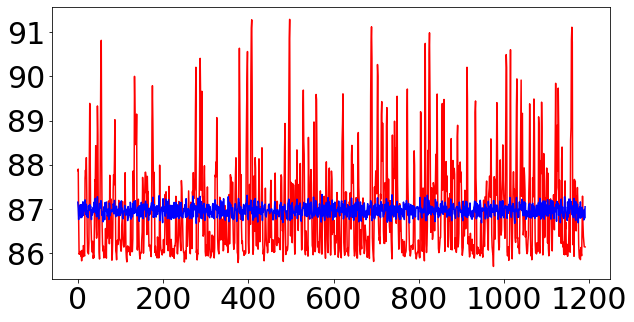

rmse: 1.0720992940778875
train_time: 8.408509492874146


In [27]:
#训练结果画图
h_state = torch.randn(1, 1, HIDDEN_SIZE)
c_0 = torch.randn(1, 1, HIDDEN_SIZE)
truth_height = [] #观测值
prediction = [] #预测结果
for X,y in TrainDataLoader_1:
    X=X.reshape(10,-1,6)
    pp, test = lstm(X, h_state, c_0)  #预测
    h_state = test[0].detach()
    c_0 = test[1].detach()
    
    #展平
    tt = y.data.numpy().reshape(-1, 1)
    pp = pp.data.numpy().reshape(-1, 1)
    
    #反归一化
    tt = y_scaler_train.inverse_transform(tt)
    pp = y_scaler_train.inverse_transform(pp)
    
    #最后一个值是我们的预测的时刻
    prediction.append(pp[9][0])
    truth_height.append(tt[9][0])

# 画图
num = list(range(1191))
# 红色是实际，蓝色是预测
plt.figure(1, figsize=(10, 5))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.plot(num, truth_height, 'r-')
plt.plot(num, prediction, 'b-')
plt.draw(); plt.pause(0.05)  

truth_height = np.array(truth_height)
prediction = np.array(prediction)
error = truth_height - prediction
rmse = np.mean(error ** 2) ** 0.5
print("rmse:", rmse.item())
print("train_time:", train_time)

In [28]:
#测试集结果
h_state = torch.randn(1, 1, HIDDEN_SIZE)
c_0 = torch.randn(1, 1, HIDDEN_SIZE)
truth_height = [] #观测值
prediction = [] #预测结果
for X,y in TestDataLoader:
    X=X.reshape(50,-1,6)
    pp, test = lstm(X, h_state, c_0)
    h_state = test[0].detach()
    c_0 = test[1].detach()
    
    tt = y.data.numpy().reshape(-1, 1)
    pp = pp.data.numpy().reshape(-1, 1)
    
    tt = y_scaler_test.inverse_transform(tt)
    pp = y_scaler_test.inverse_transform(pp)
    
    prediction.append(pp[49][0]+1)
    truth_height.append(tt[49][0])


# 画图
num = list(range(251))
# 红色是实际，蓝色是预测
plt.figure(1, figsize=(10, 5))
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

plt.plot(num, truth_height, 'r-')
plt.plot(num, prediction, 'b-')
plt.draw(); plt.pause(0.05)  

truth_height = np.array(truth_height)
prediction = np.array(prediction)
error = truth_height - prediction
rmse = np.mean(error ** 2) ** 0.5
print("rmse:", rmse.item())
print("train_time:", train_time)

RuntimeError: shape '[50, -1, 6]' is invalid for input of size 60

In [ ]:
# print(loss_array)
num = list(range(epochs))
plt.plot(num, loss_array, 'r-')